In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad


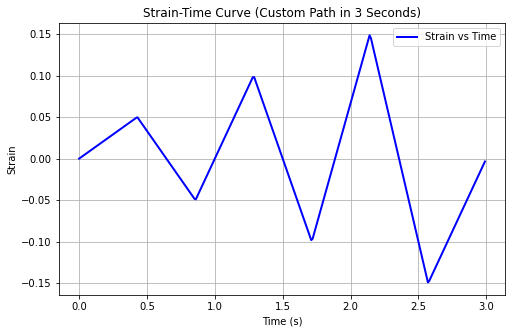

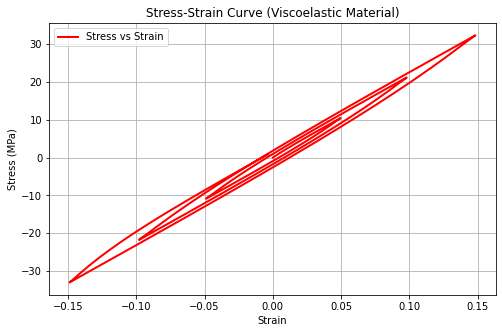

In [2]:
# Parameters for the viscoelastic model
A = 200  # Elastic stiffness matrix in MPa
Q = 10   # Kernel decay rate
D = 50   # Damping coefficient in MPa·s
dt = 0.01  # Time step

# Time array
total_time = 3  # Total time for custom strain path (3 seconds)
time = np.arange(0, total_time, dt)  # Time array

# Define custom strain points and corresponding time points
custom_strain_points = [0, 0.05, -0.05, 0.1, -0.1, 0.15, -0.15, 0]
custom_time_points = np.linspace(0, total_time, len(custom_strain_points))

# Interpolate to create the strain path
strain = np.interp(time, custom_time_points, custom_strain_points)

# Strain rate (dE/dt) using numerical differentiation
strain_rate = np.gradient(strain, dt)

# Initialize stress array for storing computed stress values
stress = np.zeros_like(time)

# Compute stress using the convolution integral
for i in range(1, len(time)):
    # Elastic stress component
    elastic_stress = A * strain[i]
    
    # Viscoelastic stress component
    viscoelastic_stress = 0
    for j in range(i):
        kernel = np.exp(-Q * (time[i] - time[j]))  # Decaying kernel
        viscoelastic_stress += kernel * D * strain_rate[j] * dt  # Convolution for viscoelastic contribution
    
    # Total stress is the sum of elastic and viscoelastic components
    stress[i] = elastic_stress + viscoelastic_stress

# Plot the strain-time curve
plt.figure(figsize=(8, 5))
plt.plot(time, strain, label="Strain vs Time", color='b', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Strain")
plt.title("Strain-Time Curve (Custom Path in 3 Seconds)")
plt.grid(True)
plt.legend()
plt.show()

# Plot the stress-strain curve
plt.figure(figsize=(8, 5))
plt.plot(strain, stress, label="Stress vs Strain", color='r', linewidth=2)
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.title("Stress-Strain Curve (Viscoelastic Material)")
plt.grid(True)
plt.legend()
plt.show()

# Convert to torch tensors for training
strain_tensor = torch.tensor(strain, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)
stress_tensor = torch.tensor(stress, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)

# Create dataset and dataloader
dataset = TensorDataset(strain_tensor, stress_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)




In [3]:
# Define the SoftplusSquared activation for convexity enforcement
class SoftplusSquared(nn.Module):
    def forward(self, x):
        return torch.log(1 + torch.exp(x)) ** 2

# Define the neural network for Potential W (elastic part)
class PotentialW(nn.Module):
    def __init__(self):
        super(PotentialW, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 64),
            SoftplusSquared(),
            nn.Linear(64, 64),
            SoftplusSquared(),
            nn.Linear(64, 1)
        )

    def forward(self, strain):
        return self.fc(strain)
    

# Define the neural network for Potential V (viscoelastic part)
class PotentialV(nn.Module):
    def __init__(self):
        super(PotentialV, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 64),
            SoftplusSquared(),
            nn.Linear(64, 64),
            SoftplusSquared(),
            nn.Linear(64, 1)
        )
        self.C1 = nn.Parameter(torch.tensor([1.0]), requires_grad=True)
        self.C2 = nn.Parameter(torch.tensor([1.0]), requires_grad=True)

    def forward(self, strain, alpha):
        delta = self.C1 * strain + self.C2 * alpha
        return self.fc(delta)

# Define the neural network for Potential G (dissipation potential)
class PotentialG(nn.Module):
    def __init__(self):
        super(PotentialG, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 64),
            SoftplusSquared(),
            nn.Linear(64, 64),
            SoftplusSquared(),
            nn.Linear(64, 1)
        )

    def forward(self, beta):
        return self.fc(beta)

# Define the surrogate model for alpha evolution
class AlphaSurrogate(nn.Module):
    def __init__(self):
        super(AlphaSurrogate, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(1, 64),
            SoftplusSquared(),
            nn.Linear(64, 64),
            SoftplusSquared(),
            nn.Linear(64, 1)
        )

    def forward(self, strain):
        return self.fc(strain)


In [4]:
# Define the complete viscoelastic model with alpha surrogate
class ViscoelasticModelWithAlpha(nn.Module):
    def __init__(self, W_model, V_model, G_model, alpha_surrogate):
        super(ViscoelasticModelWithAlpha, self).__init__()
        self.W_model = W_model
        self.V_model = V_model
        self.G_model = G_model
        self.alpha_surrogate = alpha_surrogate

    def forward(self, strain, alpha):
        # Step 1: Compute internal stress beta using V_model
        V = self.V_model(strain, alpha)
        V_sum = V.sum()
        beta = -grad(V_sum, alpha, create_graph=True)[0]

        # Step 2: Evolve alpha using G_model and surrogate
        alpha_evolution = self.G_model(beta)
        alpha_surrogate = self.alpha_surrogate(strain)

        # Step 3: Compute total stress using W_model and V_model
        W = self.W_model(strain)
        dW_dE = grad(W.sum(), strain, create_graph=True)[0]
        dV_dE = grad(V_sum, strain, create_graph=True)[0]
        total_stress = dW_dE + dV_dE

        return total_stress, alpha_evolution, alpha_surrogate


In [5]:
# Define the augmented loss function with penalty
def augmented_loss(predicted_stress, true_stress, alpha_surrogate, alpha_evolution, lambda_penalty=0.1):
    mse_loss = nn.MSELoss()(predicted_stress, true_stress)
    penalty_loss = lambda_penalty * torch.mean((alpha_surrogate - alpha_evolution) ** 2)
    total_loss = mse_loss + penalty_loss
    return total_loss

# Instantiate the models
W_model = PotentialW()
V_model = PotentialV()
G_model = PotentialG()
alpha_surrogate = AlphaSurrogate()

# Instantiate the viscoelastic model with the alpha surrogate
viscoelastic_model = ViscoelasticModelWithAlpha(W_model, V_model, G_model, alpha_surrogate)

# Define the optimizer
optimizer = optim.Adam(viscoelastic_model.parameters(), lr=0.001)

# Training loop
epochs = 5000
for epoch in range(epochs):
    # Loop through the data loader batches
    for batch_idx, (strain_batch, true_stress_batch) in enumerate(data_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Ensure strain_batch requires grad for computing potentials W, V, and G
        strain_batch.requires_grad_(True)

        # Initialize alpha with requires_grad=True so we can compute gradients for alpha evolution
        alpha = torch.zeros_like(strain_batch, requires_grad=True)

        # Forward pass: compute predicted stress, alpha evolution, and surrogate alpha
        predicted_stress, alpha_evolution, alpha_surrogate_output = viscoelastic_model(strain_batch, alpha)

        # Compute the augmented loss (MSE + penalty for alpha evolution)
        loss = augmented_loss(predicted_stress, true_stress_batch, alpha_surrogate_output, alpha_evolution)

        # Backward pass: compute gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

    # Print loss for monitoring every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')



Epoch 0/5000, Loss: 171.53121948242188
Epoch 100/5000, Loss: 1.6050570011138916
Epoch 200/5000, Loss: 1.7122862339019775
Epoch 300/5000, Loss: 1.842771291732788
Epoch 400/5000, Loss: 1.1639318466186523
Epoch 500/5000, Loss: 2.418952703475952
Epoch 600/5000, Loss: 2.540087938308716
Epoch 700/5000, Loss: 1.6958011388778687
Epoch 800/5000, Loss: 2.1045618057250977
Epoch 900/5000, Loss: 1.6141386032104492
Epoch 1000/5000, Loss: 1.2885619401931763
Epoch 1100/5000, Loss: 2.257587432861328
Epoch 1200/5000, Loss: 2.393923282623291
Epoch 1300/5000, Loss: 2.1566474437713623
Epoch 1400/5000, Loss: 1.590948462486267
Epoch 1500/5000, Loss: 1.0066596269607544
Epoch 1600/5000, Loss: 1.5094548463821411
Epoch 1700/5000, Loss: 2.462404251098633
Epoch 1800/5000, Loss: 2.102341413497925
Epoch 1900/5000, Loss: 2.455697536468506
Epoch 2000/5000, Loss: 1.4351575374603271
Epoch 2100/5000, Loss: 3.547536849975586
Epoch 2200/5000, Loss: 1.7043272256851196
Epoch 2300/5000, Loss: 1.9841591119766235
Epoch 2400/500

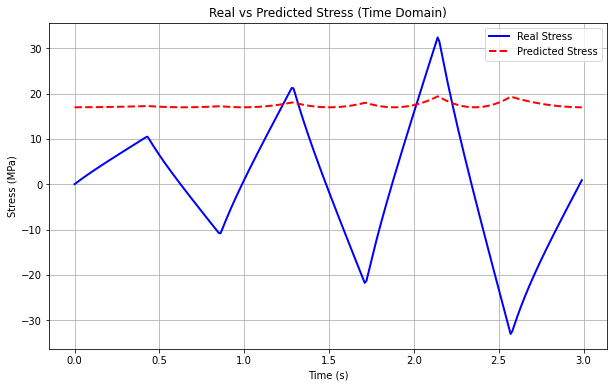

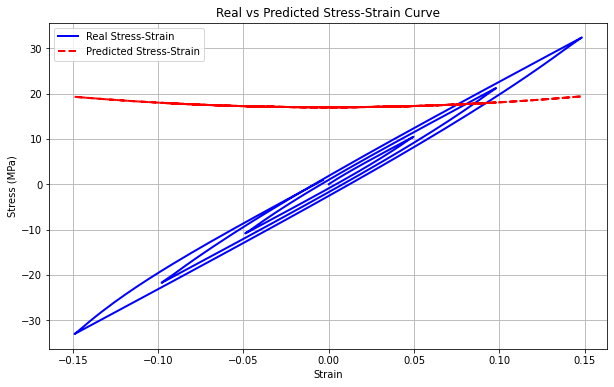

: 

In [6]:
# Evaluate the model and compare with real stress
viscoelastic_model.eval()

# Forward pass to get predictions on the full dataset
with torch.no_grad():
    # Initialize alpha for inference without requires_grad=True
    alpha = torch.zeros_like(strain_tensor)

    # Forward pass through the model to get predictions without computing gradients
    predicted_stress_list = []

    # Iterate over each strain value in the dataset
    for i in range(len(strain_tensor)):
        strain = strain_tensor[i].unsqueeze(0)  # Shape (1, 1)
        alpha_i = alpha[i].unsqueeze(0)  # Shape (1, 1)

        # Use the model to compute stress using the learned potentials without needing gradients
        W_output = W_model(strain)
        V_output = V_model(strain, alpha_i)

        # Here we directly use the outputs from W_model and V_model as stress approximation
        total_stress = W_output + V_output

        # Collect the predicted stress
        predicted_stress_list.append(total_stress.item())

    # Convert the list of predicted stresses to a numpy array for plotting
    predicted_stress = np.array(predicted_stress_list)

# Convert strain and stress to numpy arrays for easier plotting
strain_np = strain_tensor.squeeze().numpy()  # Shape (N,)
stress_np = stress_tensor.squeeze().numpy()  # Shape (N,)

# Plot the real vs predicted stress vs time
plt.figure(figsize=(10, 6))
plt.plot(time, stress_np, label="Real Stress", color='b', linewidth=2)
plt.plot(time, predicted_stress, label="Predicted Stress", color='r', linestyle='--', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Stress (MPa)")
plt.title("Real vs Predicted Stress (Time Domain)")
plt.legend()
plt.grid(True)
plt.show()

# Plot the real vs predicted stress-strain curve
plt.figure(figsize=(10, 6))
plt.plot(strain_np, stress_np, label="Real Stress-Strain", color='b', linewidth=2)
plt.plot(strain_np, predicted_stress, label="Predicted Stress-Strain", color='r', linestyle='--', linewidth=2)
plt.xlabel("Strain")
plt.ylabel("Stress (MPa)")
plt.title("Real vs Predicted Stress-Strain Curve")
plt.legend()
plt.grid(True)
plt.show()
